In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quad_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan_2screens
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.utils import split_2screen_dset

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

from analysis_scripts import plot_3d_scan_data_2screens, plot_3d_scan_data_2screens_contour, create_clipped_dset, run_3d_scan_2screens

In [2]:
# load data
data_dir = '/global/cfs/cdirs/m669/rroussel/AWA_DATA/01_18_6D_PSR/reconstruction_scan'
#data_dir = '/Users/jpga/AWA_DATA/01_16_6D_PSR/reconstruction_scan'
save_dir =  '/global/cfs/cdirs/m669/rroussel/AWA_DATA/01_18_6D_PSR/reconstruction_results/scan_5'
clipped_dset = torch.load(os.path.join(save_dir, 'dset_01_18_scan_5_clipped.pt'))

In [3]:
clipped_dset.images.shape

torch.Size([9, 2, 2, 3, 300, 300])

In [4]:
# max intensity
vmax1 = clipped_dset.images[4,0,0].max()
print(vmax1)
vmax2 = clipped_dset.images[4,0,1].max()
print(vmax2)

tensor(0.0022, dtype=torch.float64)
tensor(0.0010, dtype=torch.float64)


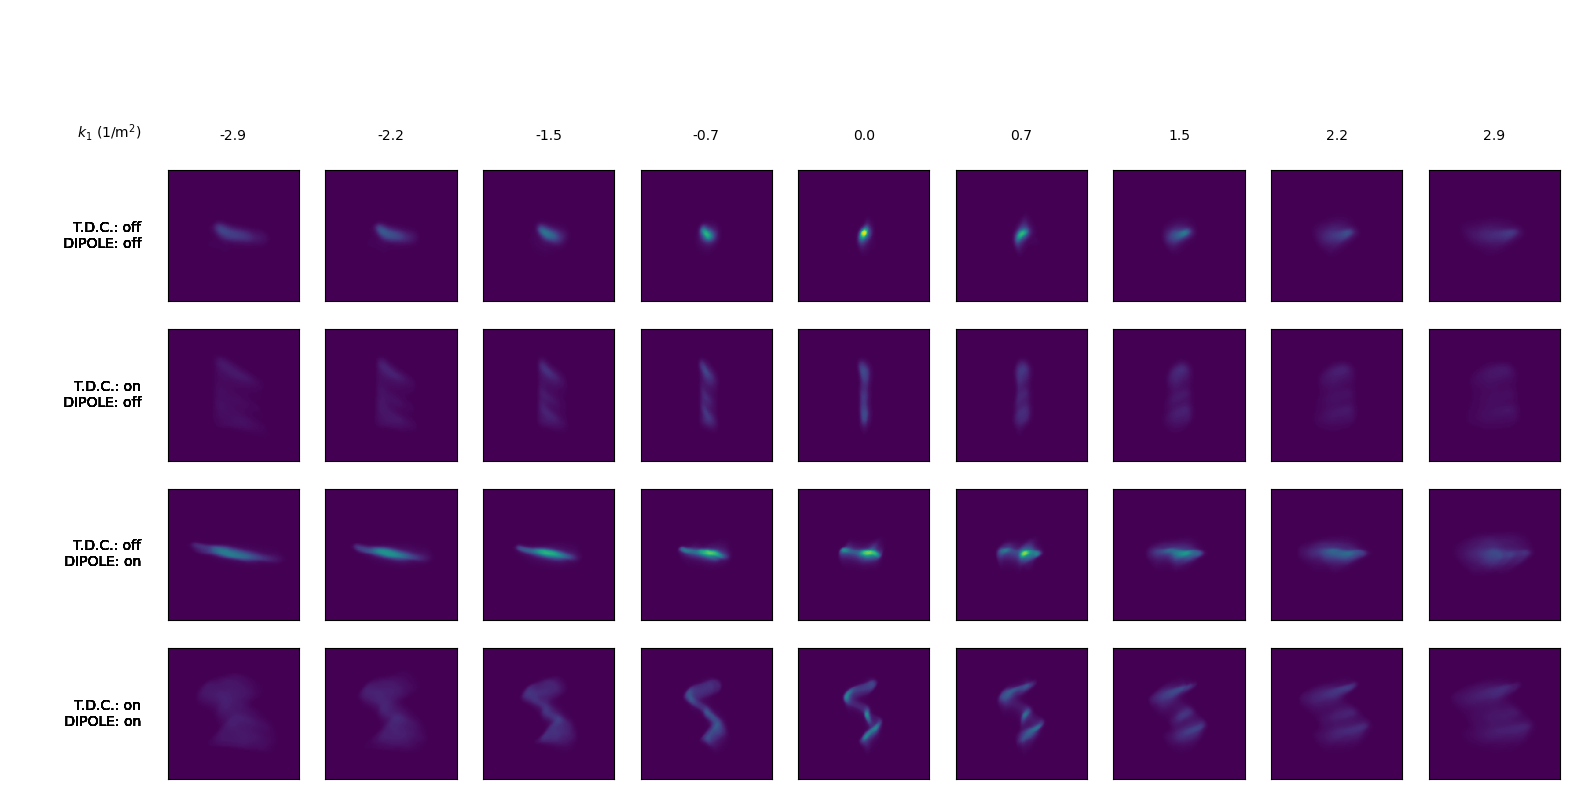

In [5]:
plot_3d_scan_data_2screens(clipped_dset, vmax1=vmax1, vmax2=vmax2)
plt.show()

In [6]:
train_dset, test_dset = split_2screen_dset(clipped_dset)

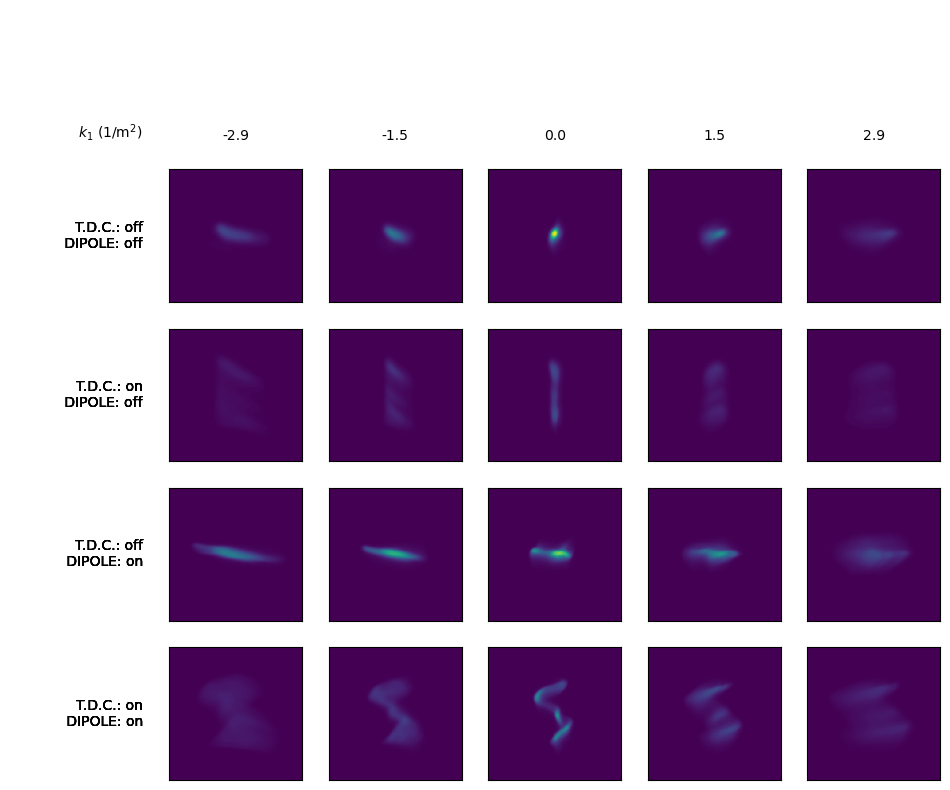

In [7]:
plot_3d_scan_data_2screens(train_dset, vmax1=vmax1, vmax2=vmax2)
plt.show()

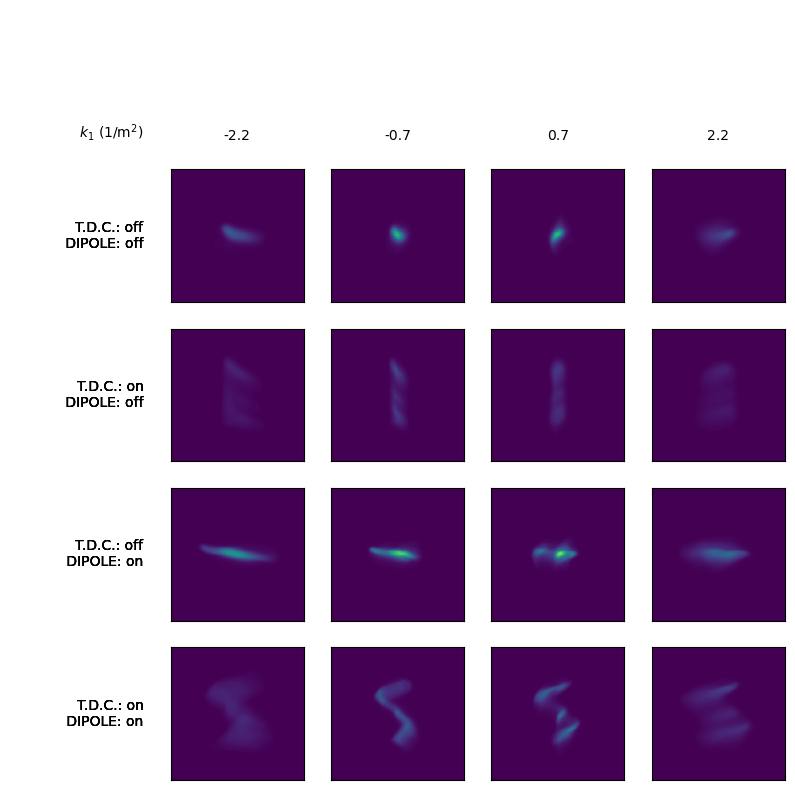

In [8]:
plot_3d_scan_data_2screens(test_dset, vmax1=vmax1, vmax2=vmax2)
plt.show()

In [9]:
from bmadx import Particle
def numpy_to_torch_particles(particle: Particle):
    '''Returns Particle with torch tensors from particles with numpy arrays.'''
    return Particle(
        x = torch.tensor(particle.x),
        px = torch.tensor(particle.px),
        y = torch.tensor(particle.y),
        py = torch.tensor(particle.py),
        z = torch.tensor(particle.z),
        pz = torch.tensor(particle.pz),
        s = torch.tensor(particle.s),
        p0c = torch.tensor(particle.p0c),
        mc2 = torch.tensor(particle.mc2)
    )
#pred_beam = numpy_to_torch_particles(torch.load('pred_beam_01_18_scan_5_centered_clipped.pt'))
pred_beam = numpy_to_torch_particles(torch.load(os.path.join(save_dir,'beam_10000.pt')))

In [10]:
test_dset.params.shape

torch.Size([4, 2, 2, 3])

In [11]:
# diagnostic beamline:
p0c = 43.3e6
lattice0 = quad_tdc_bend(p0c=p0c, dipole_on=False)
lattice1 = quad_tdc_bend(p0c=p0c, dipole_on=True)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [0, 2, 4] 

# create 2 diagnostic screens: 
def create_screen(size, pixels):
    bins = torch.linspace(-size/2, size/2, pixels)
    bandwidth = (bins[1]-bins[0]) / 2
    return ImageDiagnostic(bins, bins, bandwidth)
width = 300
size_0 = 30.22*1e-3*width/700
size_1 = 26.96*1e-3*width/700
screen0 = create_screen(size_0, width)
screen1 = create_screen(size_1, width)

In [12]:
pred_beam

Particle(x=tensor([ 0.0031, -0.0018, -0.0004,  ...,  0.0010, -0.0027, -0.0004]), px=tensor([-1.2934e-03,  7.2663e-04,  3.3011e-04,  ..., -2.8345e-04,
         1.2357e-03,  3.5344e-05]), y=tensor([ 0.0004, -0.0006,  0.0002,  ...,  0.0002,  0.0002, -0.0008]), py=tensor([-3.3591e-04,  3.5544e-04, -6.1274e-05,  ...,  3.6425e-04,
         2.6821e-04,  8.8698e-05]), z=tensor([-0.0006, -0.0005,  0.0007,  ..., -0.0006, -0.0003,  0.0006]), pz=tensor([ 1.4476e-03,  2.3917e-03, -8.7211e-05,  ...,  3.8763e-03,
        -8.3069e-04, -2.2949e-03]), s=tensor(0.), p0c=tensor(43300000.), mc2=tensor(510998.9375))

In [13]:
pred_dset = run_3d_scan_2screens(
    pred_beam,
    lattice0,
    lattice1,
    screen0,
    screen1,
    params=test_dset.params,
    ids=scan_ids
)

torch.Size([4, 2, 2, 3])
torch.Size([4, 2, 3, 1])


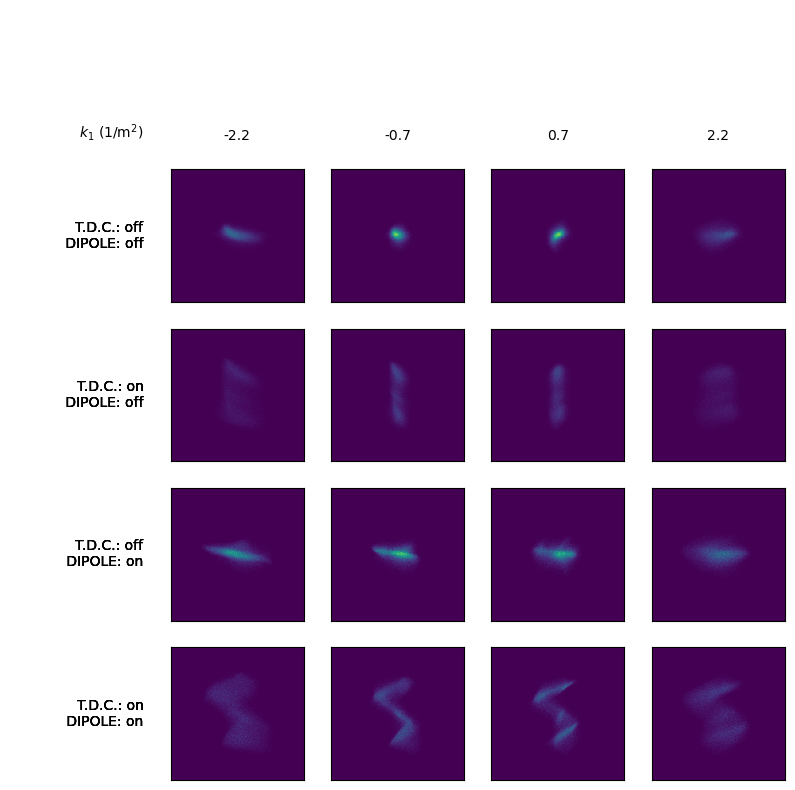

In [14]:
plot_3d_scan_data_2screens(pred_dset, vmax1=vmax1, vmax2=vmax2)
plt.show()

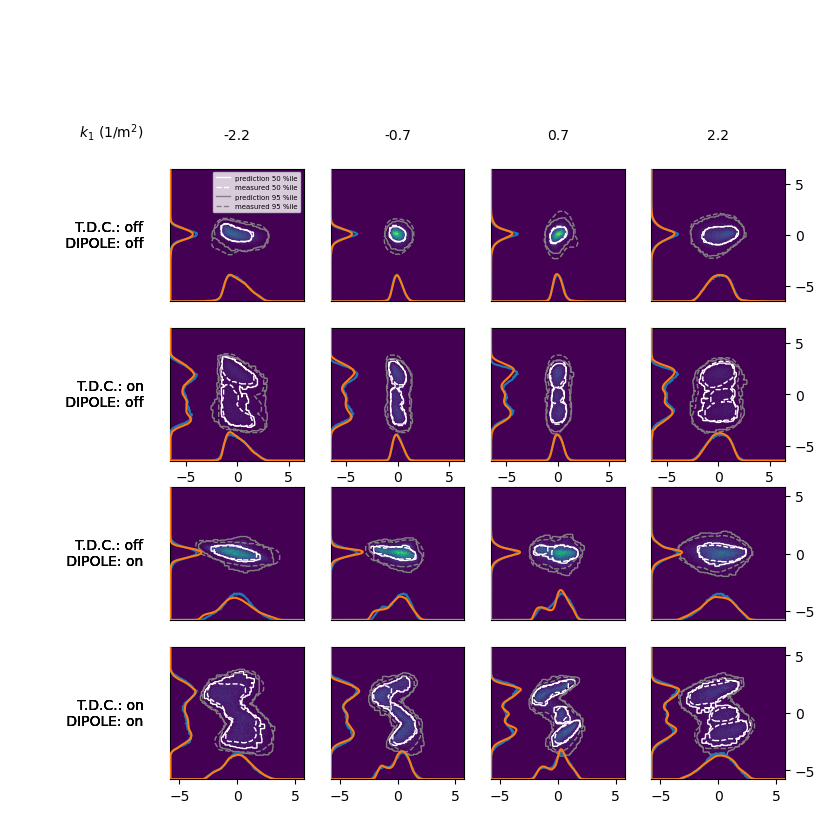

In [20]:
plot_3d_scan_data_2screens_contour(pred_dset, test_dset, screen_0_len = size_0, screen_1_len=size_1, vmax1=vmax1, vmax2=vmax2)
plt.show()

In [16]:
complete_pred_dset = run_3d_scan_2screens(
    pred_beam,
    lattice0,
    lattice1,
    screen0,
    screen1,
    params=clipped_dset.params,
    ids=scan_ids
)

torch.Size([9, 2, 2, 3])
torch.Size([9, 2, 3, 1])


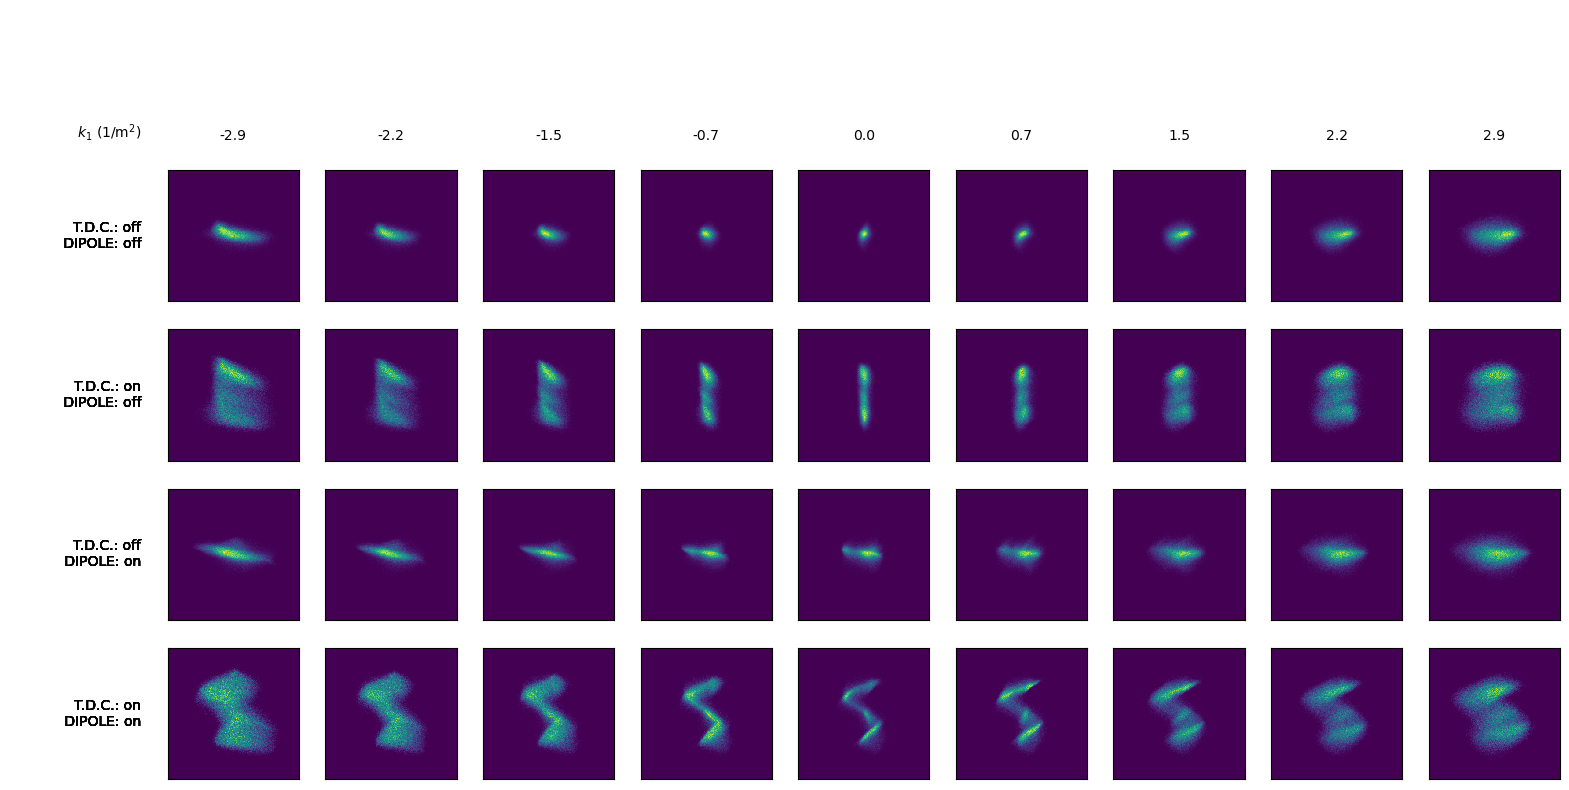

In [17]:
plot_3d_scan_data_2screens(complete_pred_dset)
plt.show()

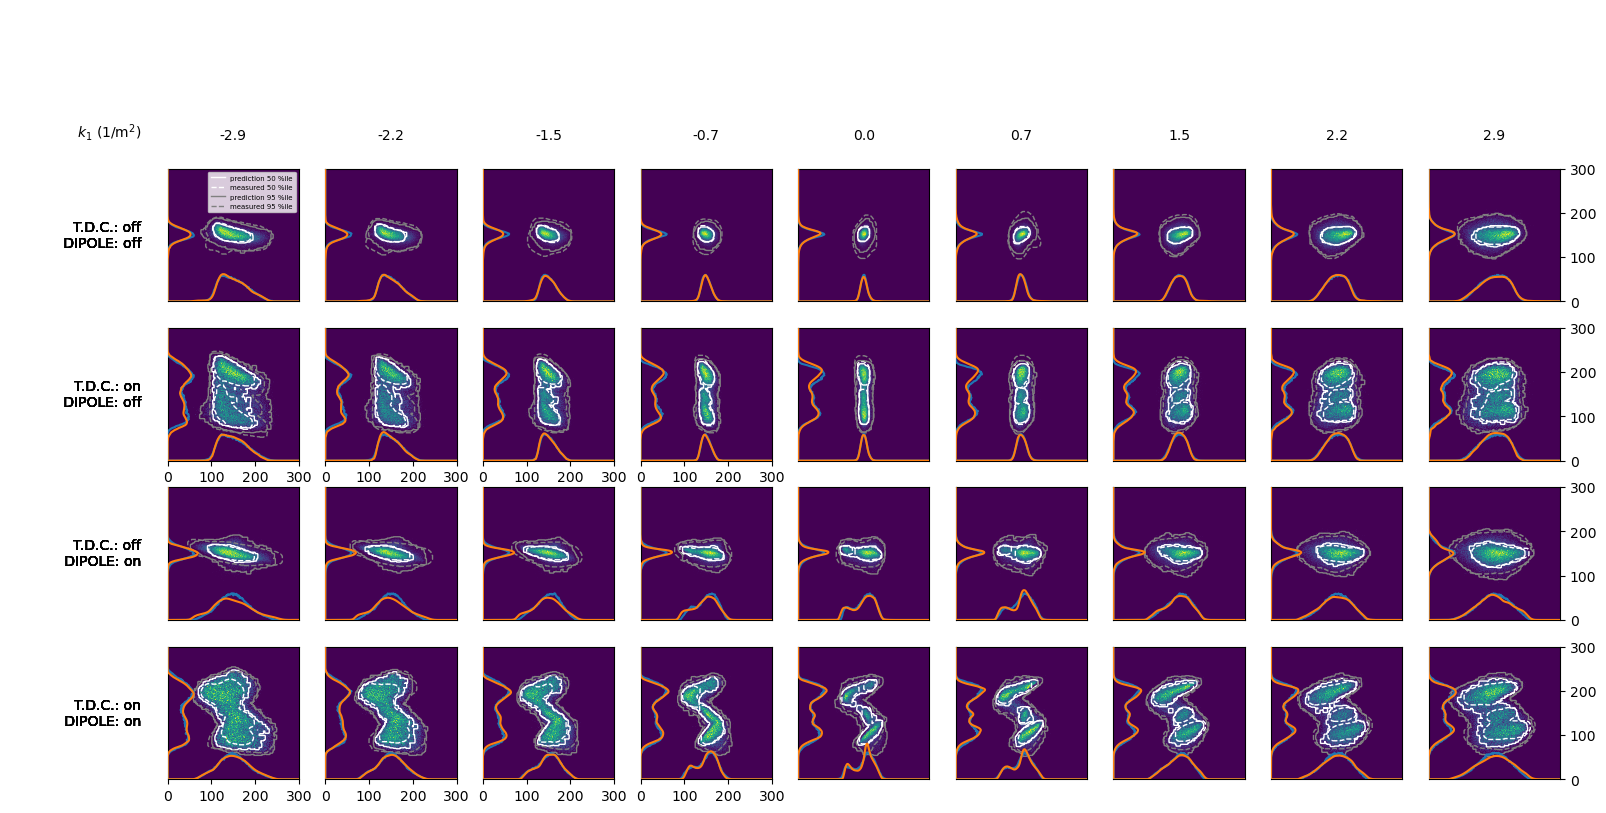

In [18]:
plot_3d_scan_data_2screens_contour(complete_pred_dset, clipped_dset)
plt.show()